# Data Science Project: Analyzing Song Popularity and Lyrics
By Josh Svehla

Data Source: https://www.kaggle.com/rakannimer/billboard-lyrics 

Each year, Billboard publishes a Hot 100 list; the top 100 performing singles from the year. This dataset contains the contents of this list between 1964-2015, and then they also scraped the web to try and add the lyrics for each song, so each of the 5100 rows contains columns for the song's positions in the Hot 100, the song name, artist, year, the songs lyrics if they could be identified, and a source column which indicates if the lyrics were found at he author's first source (metrolyrics.com), second source (songlyrics.com), or third (lyricsmode.com), and if those didn't work, there are some NA values. 

I first came across this dataset because I was hoping to find the top performing artists of history, and I don't see that being too difficult to get from this data. Since this includes lyrics, I think it would be interesting to find the most common words in more successful songs, which would be useful if you believed that the lyrics of a song would have a direct impact on if your song would be more successful. It's also possible I'll look into if over time, these lyrics popularity change at all over the time. The last information I think would be interesting to possibly look at would be the repetetiveness of lyrics in popular songs; it feels like a lot of songs are very repetitive, and I'm curious if that influences popularity or if that's changed at all over the years. 

## Hypotheses
Question: What lyrics are more common in more popular songs? Can we predict a song's popularity based off of it's lyrics?

Hypothesis:
* Song popularity cannot be very accurately predicted based off lyrics alone

Hypotheses to examine if time permits:
* Songs including the word "love" will be more popular
* Songs that are more popular share more lyrics with each other than with songs that are less popular
* Songs that are more popular have fewer unique lyrics than less popular songs
* Over time, popular song lyrics have become less complex

## Dataset
#### Original Author
Kaylin Pavlik
#### Source where I found the data
https://www.kaggle.com/rakannimer/billboard-lyrics
#### Inspiration
The author wanted to determine what makes a songs lyrics popular
#### Description of Dataset
Each year, Billboard publishes a Hot 100 list; the top 100 performing singles from the year. This dataset contains the contents of this list between 1964-2015, and then they also scraped the web to try and add the lyrics for each song, so each of the 5100 rows contains columns for the song's positions in the Hot 100, the song name, artist, year, the songs lyrics if they could be identified, and a source column which indicates if the lyrics were found at he author's first source (metrolyrics.com), second source (songlyrics.com), or third (lyricsmode.com), and if those didn't work, there are some NA values. 

## Data Preprocessing
I start out by importing the data and checking out the data

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

# sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

df = pd.read_csv("billboard_lyrics_1964-2015.csv", encoding='latin-1')
print(df.head(10))
print("\nDataframe Info:\n")
print(df.info())

   Rank                                      Song                         Artist  Year                                             Lyrics  Source
0     1                               wooly bully  sam the sham and the pharaohs  1965  sam the sham miscellaneous wooly bully wooly b...     3.0
1     2  i cant help myself sugar pie honey bunch                      four tops  1965   sugar pie honey bunch you know that i love yo...     1.0
2     3                i cant get no satisfaction             the rolling stones  1965                                                        1.0
3     4                       you were on my mind                        we five  1965   when i woke up this morning you were on my mi...     1.0
4     5              youve lost that lovin feelin         the righteous brothers  1965   you never close your eyes anymore when i kiss...     1.0
5     6                                  downtown                   petula clark  1965   when youre alone and life is making

There are 5100 entries (51 years, 100 songs each year), but only 4913 have values for lyrics/source. This means that for 187 songs, the three lyrics websites the author scraped weren't able to find lyrics. This is less than 4% of the dataset, and since the lyrics are a major component of the analysis and they can't easily be imputed, I'll just be removing these rows from the dataset.

For cleaning the data, the lyrics are all I need to worry about cleaning. First, I need to convert them from an object to a string. After some research, I found nltk.corpus stopwords, which in NLP, stopwords are words that aren't important because they're so common: things like "a" and "the". First, I'll make sure everything's lowercase so it will consistently match with the stopwords, then use a simple lambda statement to remove the stopwords.

In [144]:
df = df.dropna()
df['Lyrics'] = df['Lyrics'].astype('str')

df['Lyrics'] = df['Lyrics'].str.lower().str.split()
df['Lyrics'] = df['Lyrics'].apply(lambda x : [item for item in x if item not in stop])

print(df.head(10))
print("\nDataframe Info:\n")
print(df.info())

   Rank                                      Song                         Artist  Year                                             Lyrics  Source
0     1                               wooly bully  sam the sham and the pharaohs  1965  [sam, sham, miscellaneous, wooly, bully, wooly...     3.0
1     2  i cant help myself sugar pie honey bunch                      four tops  1965  [sugar, pie, honey, bunch, know, love, cant, h...     1.0
2     3                i cant get no satisfaction             the rolling stones  1965                                                 []     1.0
3     4                       you were on my mind                        we five  1965  [woke, morning, mind, mind, got, troubles, who...     1.0
4     5              youve lost that lovin feelin         the righteous brothers  1965  [never, close, eyes, anymore, kiss, lips, ther...     1.0
5     6                                  downtown                   petula clark  1965  [youre, alone, life, making, lonely,

## Data Analysis and Visualization
First, for a visual analysis, I found that WordCloud can allow me to make a wordcloud to visually see more frequently used words as larger, which is a cool data visualization. I'll make a wordcloud for songs ranked 1-25 then one for 75-100 to see if I can tell any difference. After this, I'll then divide up the lyrics and assign them an average popularity score for the songs they're used in, so then we'll see which words are used the most frequently.

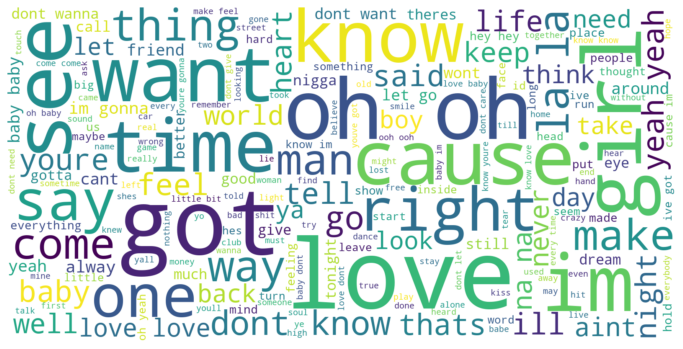

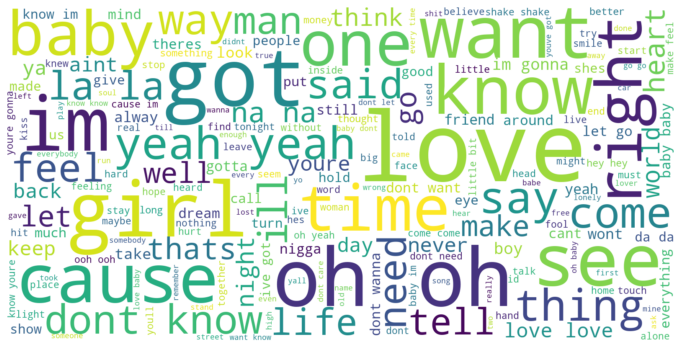

In [145]:
popular_words = []
for w in df.loc[df['Rank'] > 25]['Lyrics']:
    lyrics = ' '.join(w)
    popular_words.append(lyrics)
cloud_words = pd.Series(popular_words).str.cat(sep=' ')

from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800,max_font_size=230, background_color='white').generate(cloud_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

unpopular_words = []
for w in df.loc[df['Rank'] < 75]['Lyrics']:
    lyrics = ' '.join(w)
    unpopular_words.append(lyrics)
cloud_words = pd.Series(unpopular_words).str.cat(sep=' ')

from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800,max_font_size=230, background_color='white').generate(cloud_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [146]:
# dict will use word as a key, mapping to a tuple of (frequency, rankings total, rankings average)
words = {}
for index, row in df.iterrows():
    for w in row['Lyrics']:
        if w in words:
            occurences = words[w][0] + 1
            total_rank = words[w][1] + row['Rank']
            avg_rank = total_rank / occurences
            words[w] = (occurences, total_rank, avg_rank)
        else:
            words[w] = (1, row['Rank'], row['Rank'])

print('Sorted by Occurences:')
print('Word\tOccurences\tAverage Rank')
print('--------------------------------')
i = 0
for w in sorted(words.items(), key=lambda x: x[1][0], reverse=True):
    if(i < 10):
        i += 1
        print(w[0] + '\t' + str(w[1][0]) + '\t' + str(w[1][2]))

Sorted by Occurences:
Word	Occurences	Average Rank
--------------------------------
love	15283	50.143296473205524
im	14278	49.39123126488304
dont	11587	51.30361612151549
know	11166	50.60379724162637
like	10949	49.87807105671751
oh	9736	48.10137633525061
baby	9098	49.62892943504067
got	8289	50.09977078055254
get	8265	50.42577132486388
youre	6592	47.02214805825243


There are a ton of words here and it looks like a lot don't occur in many songs, which could skew how a lyric may affect popularity if it's not in enough songs to create a strong average ranking. So, I'll graph the word occurences to get a better idea of where to cutoff the words.

Text(0, 0.5, 'Number of Words')

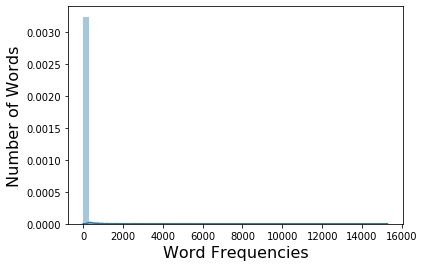

In [147]:
frequencies = []
for w in sorted(words.items(), key=lambda x: x[1][0], reverse=True):
    frequencies.append(w[1][0])

sns.distplot(frequencies)
plt.xlabel("Word Frequencies", size=16)
plt.ylabel("Number of Words", fontsize=16)

These are a ton of words with very few occurences. Looks like anything less frequent than about, let's say, 50 occurences we can get rid of. This way, we only have words that are occuring in an adequate amount of songs. So I'll eliminate words from our list that occur fewer than 50 times, then take a look at them sorted by average ranking

In [148]:
words_copy = words.copy()
for key, value in words.items():
    if value[0] <= 50:
        del words_copy[key]


print('Sorted by Average Rank (if more than 50 occurences)')
print('Word\tOccurences\tAverage Rank')
print('--------------------------------')
i = 0
for w in sorted(words_copy.items(), key=lambda x: x[1][2], reverse=False):
    if(i < 10):
        i += 1
        print(w[0] + '\t' + str(w[1][0]) + '\t' + str(w[1][2]))


Sorted by Average Rank (if more than 50 occurences)
Word	Occurences	Average Rank
--------------------------------
shoop	63	14.0
mony	108	16.537037037037038
willy	56	19.267857142857142
glamorous	54	19.64814814814815
awimoweh	60	21.0
louie	56	21.357142857142858
thong	90	21.488888888888887
boom	305	21.81639344262295
fever	73	22.671232876712327
tonights	56	23.321428571428573


Now I'll display what our new histogram looks like with the shortened word list as well as some stats about the words

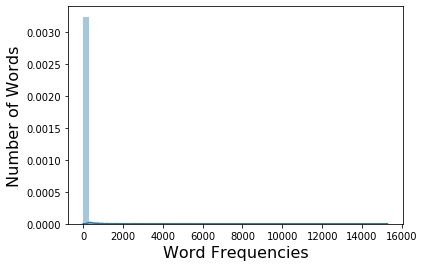

Mean word frequency: 20.46098042480318
Median word frequency: 1
Standard Deviation of word frequency: 227.4977606918235


In [149]:
frequencies = []
for w in sorted(words.items(), key=lambda x: x[1][0], reverse=True):
    frequencies.append(w[1][0])

sns.distplot(frequencies)
plt.xlabel("Word Frequencies", size=16)
plt.ylabel("Number of Words", fontsize=16)
plt.show()

import statistics
print('Mean word frequency: ' + str(statistics.mean(frequencies)))
print('Median word frequency: ' + str(statistics.median(frequencies)))
print('Standard Deviation of word frequency: ' + str(statistics.stdev(frequencies)))

## Data Modeling and Prediction

Next, I learned about learning to rank algorithms in order to try and predict if a song will be higher or lower in the Billboard top 100 based on it's lyrics. To start, I'm trying a point-wise prediction method. First, I'll split my dataset into training and testing data and if a song is ranked 1-25 in the training set, I'll assign it a label of 1. If it's 75-100, it gets a 0, and 25-75 get removed from the training set. Then I'll convert the lyrics to a bag of words and finally, train and test with an SGD classifier.

C:\Users\svehlajj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


AUC:  0.5335862599970195


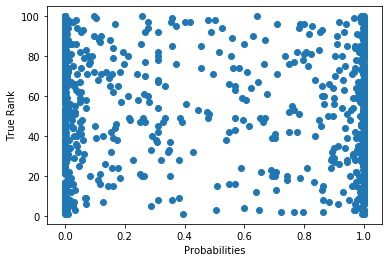

In [150]:
from sklearn.metrics import roc_auc_score as AUC
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

train_i, test_i = train_test_split( np.arange( len( df )), train_size = 0.8, random_state = 44 )

train = df.iloc[train_i, :]
test = df.iloc[test_i, :]

## Remove the middle 50 elements. Then, ranks 1-25 are labelled 1 while ranks 75-100 are labelled 0
train = train[(train['Rank'] < 25) | (train['Rank'] > 75)]
train['Label'] = train['Rank'].map(lambda r: 1 if r < 25 else 0)

## Since this will be for testing, we won't cut out the middle 50 but just
## assign anything 1-50 a label of 1 and 51-100 a 0, so we'll see if the 
## model can predict if a song is in the top 50 or bottom 50
test['Label'] = test['Rank'].apply(lambda r: 1 if r <= 50 else 0)

clean_train = []
for lyric in train['Lyrics']:
    clean_train.append( " ".join(lyric) )

clean_test = []
for lyric in test['Lyrics']:
    clean_test.append( " ".join(lyric) )

    
vectorizer = TfidfVectorizer(binary=True, norm=False, use_idf=False, min_df=5)


train_data_features = vectorizer.fit_transform( clean_train )
test_data_features = vectorizer.transform( clean_test )


model = SGDClassifier(loss="log", max_iter=1000, tol=1e-3)
model.fit( train_data_features, train['Label'] )
p = model.predict_proba( test_data_features )

print('AUC: ', AUC( test["Label"].values, p[:,1] ))
plt.scatter(p[:,1], test["Rank"])
plt.xlabel('Probabilities')
plt.ylabel('True Rank')
plt.show()

Point-wise clearly is not accurate at all, so I'll try pair-wise to see if the prediction can be improved at all or if lyrics are really that poor of an estimator for Billboard top 100 position. I'll start by taking much smaller slices for the training and testing sets since this algorithm involves comparing every elemnt with every other element in the set. So after this split, I'll vectorize lyrics into bag of words and iterate through each set, comparing it to every other element in the set. If rank1 > rank2, it'll get labelled 1, else 0, then the difference in the sparse matrices is added to a series. These labels and lyric differences will be used to train and test our classifier.

AUC:  0.5192081283814448


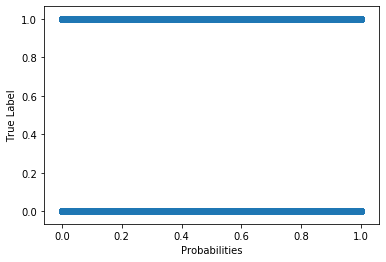

In [153]:
train_i, test_i = train_test_split( np.arange( len( df )), train_size = 0.1, random_state = 44 )

train = df.iloc[train_i, :]
test = df.iloc[test_i, :]
# Cut down test to only 400 elements
test = test.iloc[:400]

clean_train = []
for lyric in train['Lyrics']:
    clean_train.append( " ".join(lyric) )

clean_test = []
for lyric in test['Lyrics']:
    clean_test.append( " ".join(lyric) )
    
vectorizer = TfidfVectorizer(binary=True, norm=False, use_idf=False, min_df=5)

train_data_features = vectorizer.fit_transform( clean_train )
test_data_features = vectorizer.transform( clean_test )


train_labels = []
train_diff = []
i1 = 0
i2 = 0
for idx1, row1 in train.iterrows():
    for idx2, row2 in train.iterrows():
        if idx1 != idx2:
            train_labels.append(1 if row1['Rank'] > row2['Rank'] else 0)
            a = (train_data_features[i1, :] - train_data_features[i2, :]).toarray()
            train_diff.append(a[0])
        i2+= 1
    i2 = 0
    i1+=1
    
train_diff = np.array(train_diff)

test_labels = []
test_diff = []
i1 = 0
i2 = 0
for idx1, row1 in test.iterrows():
    for idx2, row2 in test.iterrows():
        if idx1 != idx2:
            test_labels.append(1 if row1['Rank'] > row2['Rank'] else 0)
            a = (test_data_features[i1, :] - test_data_features[i2, :]).toarray()
            test_diff.append(a[0])
        i2+= 1
    i2 = 0
    i1+=1
    
test_diff = np.array(test_diff)


model = SGDClassifier(loss="log", max_iter=1000, tol=1e-3)
model.fit( train_diff, train_labels )
p = model.predict_proba( test_diff )

print('AUC: ', AUC( test_labels, p[:,1] ))
plt.scatter(p[:,1], test_labels)
plt.xlabel('Probabilities')
plt.ylabel('True Label')
plt.show()

## Results Analysis
Judging by both AUC and graph results, both point-wise and pair-wise ranking algorithms found that lyrics cannot be used to accurately predict a song's position in the Billboard top 100, so this did not disprove my hypothesis. From how close these results were to just randomly guessing, it's safe to say this is significant. The experiment could be improved by bringing in song lyrics from songs that didn't make the top 100 to potentially judge between those songs and songs popular enough to make it into the top 100. It would also be interesting to bring in more info about each song like genre, beats per minute, and chord structures to see if those have a better correlation to popularity.

Overall I enjoyed this assignment, it was a lot of work to learn about ranking algorithms but I learned a lot about them and learned more about training and fitting models in the process. I would definitely consider expanding on this project more, the project wasn't easy but it was fun